In [20]:
import numpy as np
import geopandas as gpd
#import geoplot as gplt
import contextily as ctx

import matplotlib.pyplot as plt

# Árvores

Primeiro precisamos fazer o download dos arquivos 'shapefile' ([link](http://geosampa.prefeitura.sp.gov.br/PaginasPublicas/downloadIfr.aspx?orig=DownloadCamadas&arq=09_Verde%20e%20Recursos%20Naturais%5C%5CArboriza%E7%E3o%20Vi%E1ria%5C%5CShapefile%5C%5CSIRGAS_SHP_arvore&arqTipo=Shapefile)).

No código abaixo os conteúdos do arquivo zip foram extraídos numa pasta chamada
`SIRGAS_SHP_arvores`.

Aqui usaremos o geopandas (um tipo de extensão do pandas) para ler os dados
de posições de árvores do arquivo shapefile em si `.shp`. Note que também
fazemos uso do arquivo de projeção `.prj` que denota o sistema de coordenadas (`CRS`)
usado no arquivo shapefile, qual modelo (datum) está sendo usado
para caracterizar o planeta terra (=D) e também qual o alcance desse `CRS` (um `CRS` não precisa necessariamente abordar todo o planeta).

A parte do encoding é importante pois temos caracteres com acentuação.

In [10]:
arvore_df = gpd.read_file('SIRGAS_SHP_arvores/SIRGAS_SHP_arvore_.shp',
                       encoding='utf-8',
                      crs='SIRGAS_SHP_arvores/SIRGAS_SHP_arvore_.prj')

Aqui podemos explorar um pouco dos dados e entender quais campos compõem este dataset. Note que além do campo `geometry` que contém as coordenadas das árvores também temos outros campos indicando uma localização textual `av_subpref`, `av_distr` e outros campos que no momento eu desconheço o significado. Contudo a equipe do geosampa tem sido super diligente e atende super rapidamente ao contato em caso de dúvidas.

Note em particular que o `CRS` não é o **wgs84** (p. ex. o que costumamos ver no google street view) aqui está sendo usado (como indicado no arquivo de projeção `.prj`) um outro `CRS` chamado **SIRGAS_2000_UTM_Zone_23S**. Pelo que eu vi todo `CRS` tem um código EPSG (um catalogo com códigos para padronização de diferentes sistemas de coordenadas).

Aparentemente todos os dados do GeoSampa usam o `CRS` **SIRGAS_2000_UTM_Zone_23S** cujo código EPSG é **epsg:31983**. O código EPSG do `CRS` **wgs84** é **epsg:4326**.

In [11]:
arvore_df

,av_subpref,av_distr,av_sisgau,av_codlog,av_codlogd,av_base,geometry
0,VILA MARIANA,MOEMA,None,38836,0,ORTOFOTOS EMPLASA,POINT (329187.277 7387899.634)
1,VILA MARIANA,MOEMA,None,38836,0,ORTOFOTOS EMPLASA,POINT (329181.760 7387904.182)
2,VILA MARIANA,MOEMA,None,38836,0,ORTOFOTOS EMPLASA,POINT (329172.255 7387912.306)
3,VILA MARIANA,MOEMA,None,38836,0,ORTOFOTOS EMPLASA,POINT (329159.687 7387922.700)
4,VILA MARIANA,MOEMA,None,38836,0,ORTOFOTOS EMPLASA,POINT (329164.589 7387918.805)
...,...,...,...,...,...,...,...
652380,VILA MARIANA,MOEMA,None,07708,9,ORTOFOTOS EMPLASA,POINT (329191.427 7387882.223)
652381,VILA MARIANA,MOEMA,None,38836,0,ORTOFOTOS EMPLASA,POINT (329188.238 7387895.363)
652382,VILA MARIANA,MOEMA,None,07708,9,ORTOFOTOS EMPLASA,POINT (329184.957 7387890.383)
652383,VILA MARIANA,MOEMA,None,38836,0,ORTOFOTOS EMPLASA,POINT (329158.291 7387860.423)


Como carregamos o arquivo de projeção juntamente ao arquivo shapefile podemos verificar qual o `CRS` associado à este dataset:

In [12]:
arvore_df.crs

<Projected CRS: EPSG:31983>
Name: SIRGAS 2000 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - 48°W to 42°W
- bounds: (-48.0, -33.5, -42.0, 5.13)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Aparentemente temos (em 15/01/2021) um bug com o geopandas e se deixarmos o `CRS` com o formato atual ele irá quebrar. Então precisamos simplificar o campo `CRS` colocando-o da seguinte forma:

In [13]:
arvore_df.crs = 'epsg:31983'
print(arvore_df.crs)

epsg:31983


A maior parte das bibliotecas e frameworks de GIS que eu vi até agora usam o `CRS` **wgs84/epsg:4326**, se tentarmos usar dados com uma projeção em um sistema que por padrão assume outra projeção dos dados teremos distorções ou efeitos inesperados, para simplificar o tratamento dos dados uma possibilidade é sempre se converter a projeção de todos os dados para **epsg:4326** como feito abaixo:

In [14]:
arvore_df = arvore_df.to_crs('epsg:4326')

# Note que agora o CRS é o epsg:4326
print(arvore_df.crs)

epsg:4326


Vemos que o valor das coordenadas muda drasticamente, no `CRS` anterior as coordenadas assumiam valores na faixa de 300 mil/7 milhões, enquanto que agora temos as coordenadas de -46 de longitude (46 oeste) e -23 de latitude (23 sul).

In [15]:
arvore_df

,av_subpref,av_distr,av_sisgau,av_codlog,av_codlogd,av_base,geometry
0,VILA MARIANA,MOEMA,None,38836,0,ORTOFOTOS EMPLASA,POINT (-46.67423 -23.61046)
1,VILA MARIANA,MOEMA,None,38836,0,ORTOFOTOS EMPLASA,POINT (-46.67428 -23.61042)
2,VILA MARIANA,MOEMA,None,38836,0,ORTOFOTOS EMPLASA,POINT (-46.67437 -23.61035)
3,VILA MARIANA,MOEMA,None,38836,0,ORTOFOTOS EMPLASA,POINT (-46.67449 -23.61025)
4,VILA MARIANA,MOEMA,None,38836,0,ORTOFOTOS EMPLASA,POINT (-46.67445 -23.61029)
...,...,...,...,...,...,...,...
652380,VILA MARIANA,MOEMA,None,07708,9,ORTOFOTOS EMPLASA,POINT (-46.67419 -23.61062)
652381,VILA MARIANA,MOEMA,None,38836,0,ORTOFOTOS EMPLASA,POINT (-46.67422 -23.61050)
652382,VILA MARIANA,MOEMA,None,07708,9,ORTOFOTOS EMPLASA,POINT (-46.67425 -23.61055)
652383,VILA MARIANA,MOEMA,None,38836,0,ORTOFOTOS EMPLASA,POINT (-46.67452 -23.61082)


Podemos agora visualizar a distribuição espacial destas ~652 mil árvores usando o `geoplot`:

**!! Pode demorar um pouco para carregar dado o número de pontos !!**

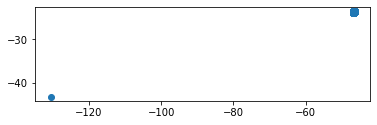

In [16]:
#https://residentmario.github.io/geoplot/plot_references/plot_reference.html
#gplt.pointplot(arvore_df)
arvore_df.plot()

Aqui podemos ver que algo está um pouco estranho, pois temos um 'blob' de pontos à direita e algo muito distante à esquerda.

Vamos averiguar qual o alcance das coordenadas dos dados.

In [17]:
# Bounds representa para cada entrada qual a coordenada máxima/mínima em questão dos eixos x e y.
# Como cada entrada é um ponto teremos 'minx e maxx' iguais assim como 'miny e maxy' para cada entrada.
bounds = arvore_df.bounds
print(bounds)

             minx       miny       maxx       maxy
0      -46.674227 -23.610464 -46.674227 -23.610464
1      -46.674281 -23.610423 -46.674281 -23.610423
2      -46.674373 -23.610348 -46.674373 -23.610348
3      -46.674495 -23.610253 -46.674495 -23.610253
4      -46.674447 -23.610289 -46.674447 -23.610289
...           ...        ...        ...        ...
652380 -46.674189 -23.610622 -46.674189 -23.610622
652381 -46.674218 -23.610503 -46.674218 -23.610503
652382 -46.674251 -23.610548 -46.674251 -23.610548
652383 -46.674516 -23.610815 -46.674516 -23.610815
652384 -46.674477 -23.610783 -46.674477 -23.610783

[652385 rows x 4 columns]


Podemos notar abaixo que o menor valor de 'x' (-130°) está muito abaixo do que esperamos para São Paulo (-46°)
Além disso também vemos que o menor 'y' (-43°) também está bem abaixo do esperado (-23°).

Para termos uma ideia, cada grau de latitude corresponde mais ou menos à 111 km, ou seja, temos algum(ns) ponto(s) à mais de 2000 km para o sul do que é esperado para São Paulo!

In [22]:
# Agora vamos verificar qual o valor mínimo e máximo das coordenadas x e y:
print(f"Menor longitude (x): {np.min(bounds['minx'])}")
print(f"Maior longitude (x): {np.max(bounds['maxx'])}")
print(f"Menor latitude (y): {np.min(bounds['miny'])}")
print(f"Maior latitude (y): {np.max(bounds['maxy'])}")

Menor longitude (x): -130.6565801170646
Maior longitude (x): -46.36534806318919
Menor latitude (y): -43.21817053895778
Maior latitude (y): -23.38859808117378


Vamos separar os dados em duas partes, àqueles que tem uma longitude (x) menor que -50° e aqueles que tem uma longitude maior que isso:

In [23]:
low_lon_idx = bounds[bounds['minx'] < -50].index
normal_lon_idx = bounds[bounds['minx'] >= -50].index

# Aqui podemos ver que temos somente 1 ponto com uma longitude tão baixa:
print(len(low_lon_idx))
print(len(normal_lon_idx))

1
652384


Parece que temos apenas um único ponto com as coordenadas talvez incorretas, a variável `low_lon_idx` guarda agora o índice (com relação ao *dataframe* `arvore_df`) de todas as entradas (somente uma) com longitude inferior à -50°.

Podemos ver abaixo que a entrada problemática é a 5017:

In [24]:
low_lon_idx

Int64Index([5017], dtype='int64')

Vamos ver à qual registro esse(s) índice(s) corresponde(m):

In [25]:
arvore_df.iloc[low_lon_idx]

,av_subpref,av_distr,av_sisgau,av_codlog,av_codlogd,av_base,geometry
5017,LAPA,BARRA FUNDA,None,290378,3,ORTOFOTOS EMPLASA,POINT (-130.65658 -43.21817)


Realmente deve ser um erro dado que o bairo da Barra Funda ainda fica em São Paulo e portanto não pode ter tais coordenadas.

(Por curiosidade essas coordenadas ficam próximas ao centro da parte Sul do Oceano Pacífico)

Agora vamos criar um subconjunto do dataframe `arvore_df`, que chamaremos de `subarvore_df` contendo somente as árvores cujas posições parecem estar corretas (cujos indices estão armazenados na variável `normal_lon_idx`):


In [26]:
subarvore_df = arvore_df.iloc[normal_lon_idx]

e vamos novamente tentar visualizar a distribuição espacial somente destas árvores:

**!! Pode demorar um pouco para carregar dado o número de pontos !!**

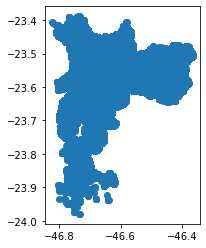

In [27]:
subarvore_df.plot()

# Cortiços e outros dados de habitação

Agora vamos ver um segundo exemplo um shapefile do GeoSampa com dados de cortiços mapeados.

Talvez tenhamos algum problema para definir 'cortiços, favelas e loteamentos irregulares' pois aparentemente a definição destes varia um pouco na literatura, mas de acordo com o livro **Caracterização e tipologia dos assentamentos precários brasileiros : o caso do Rio de Janeiro** (disponível publicamente pelo repositório do IPEA [link](http://repositorio.ipea.gov.br/handle/11058/9620)):

- Cortiços são casas de aluguel que compartilham um mesmo terreno (e.g. mesmo quintal)
- Loteamento irregular são parcelas de terreno que foram registradas na prefeitura mas não possuem a validação da prefeitura (com relação ao acesso a luz elétrica, rede de esgotos e outros fatores).
- Loteamentos clandestinos não possuem nem sequer registro na prefeitura (e portanto podem ser por exemplo zonas de manancial)
- Por fim favelas são ocupações irregulares do solo tanto público como privado (mas não possuem um agente de vendas envolvido como no caso dos loteamentos).

Carregamos os dados de cortiços da mesma forma como fizemos com o das árvores, contudo desta vez não temos o arquivo de projeção `.prj`. Portanto iremos inserir manualmente o `CRS` através do seu código EPSG mais a frente.

O atributo `index_col=0` simplesmente informa que usaremos a primeira coluna do arquivo como índice do dataframe (neste arquivo é um índice que começa em 1 ao invés de zero).

In [28]:
cortico_df = gpd.read_file('SIRGAS_SHP_cortico/SIRGAS_SHP_cortico.shp', encoding='utf-8')

Ao analizar o dataframe com os dados carregados notamos que temos uma coluna de índice chamada `ct_id` e também notamos que o campo `geometry` agora contém polígonos (diferentemente do dataframe de árvores que continha um ponto para cada árvore). Neste caso cada registro se refere a uma área delimitada por um polígono.

In [29]:
cortico_df

,ct_id,ct_nome,ct_local,ct_qt_pess,ct_area,geometry
0,1,Rua José Kauer 154,Rua José Kauer,19,135.44,"POLYGON ((336284.584 7396098.994, 336288.573 7..."
1,2,Rua Sinimbu 40,Rua Sinimbu,21,111.57,"POLYGON ((333453.039 7393830.302, 333475.848 7..."
2,3,Rua José Kauer 139,Rua José Kauer,13,230.70,"POLYGON ((336276.123 7396114.123, 336270.353 7..."
3,4,Rua Marcos Arruda 39,Rua Marcos Arruda,None,125.66,"POLYGON ((336407.683 7396006.988, 336407.370 7..."
4,5,Rua Jaguaribe 480,Rua Jaguaribe,0,232.99,"POLYGON ((331316.587 7395593.255, 331322.357 7..."
...,...,...,...,...,...,...
1474,1475,Avenida Celso Garcia 1356 1358,Avenida Celso Garcia,0,435.13,"POLYGON ((336754.833 7395991.731, 336780.970 7..."
1475,1476,Rua Dom Bosco 684,Rua Dom Bosco,None,1394.20,"POLYGON ((335063.319 7393999.137, 335065.518 7..."
1476,1477,Rua Doutor Frederico Steidel 214,Rua Doutor Frederico Steidel,10,209.97,"POLYGON ((331852.787 7395772.954, 331825.708 7..."
1477,1478,Rua Doutor Siqueira Campos 312 316,Rua Doutor Siqueira Campos,0,251.66,"POLYGON ((332990.539 7393106.305, 332991.890 7..."


Vamos usar como índice do dataframe o índice (`ct_id`) fornecido no arquivo. Além disso também iremos tratar este índice como um valor inteiro (de outra forma ele seria tratado como uma string).

Usar os índices já fornecidos pode nos ajudar eventualmente caso nos deparemos com outro conjunto de dados que faça referência aos registros deste arquivo.

In [30]:
cortico_df = cortico_df.set_index('ct_id')
cortico_df.index = cortico_df.index.astype('int')

Apesar de não termos o arquivo de projeção para este shapefile, por inspeção (i.e. tentativa e erro) podemos notar este arquivo tem como `CRS` o mesmo que o das árvores (i.e. **epsg:31983**).

Vamos reprojetar este dataframe para o **epsg:4326**  como fizemos anteriormente.

In [31]:
# Primeiro atribuímos manualmente o CRS ao dataframe
cortico_df.crs = 'epsg:31983'

# e em seguida fazemos a reprojeção
cortico_df = cortico_df.to_crs('epsg:4326')

Podemos ver que as coordenadas usadas nos polígonos agora são similares ao que vimos no caso das árvores, aparentemente este arquivo não tem nenhuma surpresa.

In [32]:
cortico_df

,ct_nome,ct_local,ct_qt_pess,ct_area,geometry
ct_id,,,,,
1,Rua José Kauer 154,Rua José Kauer,19,135.44,"POLYGON ((-46.60378 -23.53717, -46.60375 -23.5..."
2,Rua Sinimbu 40,Rua Sinimbu,21,111.57,"POLYGON ((-46.63177 -23.55736, -46.63154 -23.5..."
3,Rua José Kauer 139,Rua José Kauer,13,230.70,"POLYGON ((-46.60387 -23.53703, -46.60392 -23.5..."
4,Rua Marcos Arruda 39,Rua Marcos Arruda,None,125.66,"POLYGON ((-46.60259 -23.53801, -46.60259 -23.5..."
5,Rua Jaguaribe 480,Rua Jaguaribe,0,232.99,"POLYGON ((-46.65249 -23.54122, -46.65244 -23.5..."
...,...,...,...,...,...
1475,Avenida Celso Garcia 1356 1358,Avenida Celso Garcia,0,435.13,"POLYGON ((-46.59919 -23.53818, -46.59894 -23.5..."
1476,Rua Dom Bosco 684,Rua Dom Bosco,None,1394.20,"POLYGON ((-46.61598 -23.55600, -46.61595 -23.5..."
1477,Rua Doutor Frederico Steidel 214,Rua Doutor Frederico Steidel,10,209.97,"POLYGON ((-46.64722 -23.53966, -46.64749 -23.5..."


Vamos agora analisar a distribuição espacial destes registros:

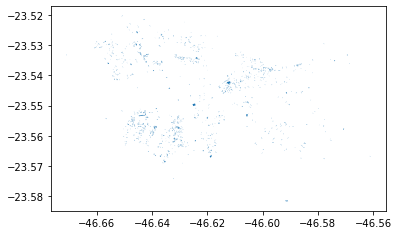

In [33]:
cortico_df.plot()

Como a área de abrangência deste arquivo é grande e cada polígono
é relativamente pequeno parece que temos um monte de pontos ao invés
polígonos, vamos visualizar um único registro de cada vez então:

Notamos que as 3 primeiras entradas correspondem à quadriláteros.

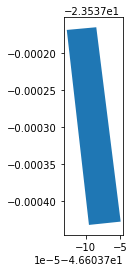

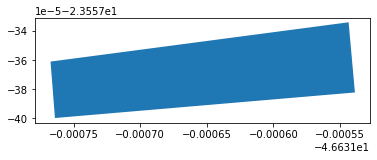

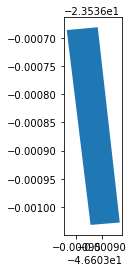

In [34]:
cortico_df.iloc[0:1].plot()
cortico_df.iloc[1:2].plot()
cortico_df.iloc[2:3].plot()

# Árvores e cortiços

Vamos visualizar agora ambos os dataframes ao mesmo tempo:

**!! Pode demorar um pouco para carregar!!**

In [35]:
subarvore_bounds = subarvore_df.bounds

Primeiro vamos encontrar qual a área que delimita os pontos das árvores (válidas) e os polígonos dos cortiços.

In [36]:
# sa de subárvores
sa_west = np.min(subarvore_bounds['minx'])
sa_east = np.max(subarvore_bounds['maxx'])
sa_south = np.min(subarvore_bounds['miny'])
sa_north = np.max(subarvore_bounds['maxy'])
print(sa_west)
print(sa_east)
print(sa_south)
print(sa_north)
subarvore_bounds

-46.82426575247804
-46.36534806318919
-23.97906585768482
-23.38859808117378


,minx,miny,maxx,maxy
0,-46.674227,-23.610464,-46.674227,-23.610464
1,-46.674281,-23.610423,-46.674281,-23.610423
2,-46.674373,-23.610348,-46.674373,-23.610348
3,-46.674495,-23.610253,-46.674495,-23.610253
4,-46.674447,-23.610289,-46.674447,-23.610289
...,...,...,...,...
652380,-46.674189,-23.610622,-46.674189,-23.610622
652381,-46.674218,-23.610503,-46.674218,-23.610503
652382,-46.674251,-23.610548,-46.674251,-23.610548
652383,-46.674516,-23.610815,-46.674516,-23.610815


In [37]:
cortico_bounds = cortico_df.bounds

In [38]:
# c de cortiços
c_west = np.min(cortico_bounds['minx'])
c_east = np.max(cortico_bounds['maxx'])
c_south = np.min(cortico_bounds['miny'])
c_north = np.max(cortico_bounds['maxy'])
print(c_west)
print(c_east)
print(c_south)
print(c_north)
cortico_bounds

-46.670955007790454
-46.56083118527701
-23.581841241200184
-23.52016683701657


,minx,miny,maxx,maxy
ct_id,,,,
1,-46.603828,-23.537432,-46.603749,-23.537165
2,-46.631767,-23.557400,-46.631539,-23.557334
3,-46.603969,-23.537032,-46.603866,-23.536681
4,-46.602592,-23.538008,-46.602313,-23.537951
5,-46.652605,-23.541566,-46.652437,-23.541222
...,...,...,...,...
1475,-46.599257,-23.538734,-46.598942,-23.538181
1476,-46.615982,-23.556086,-46.615630,-23.555680
1477,-46.647499,-23.539656,-46.647199,-23.539533


In [39]:
# Mapa da região delimitada pelas árvores
# zoom=13 é o limite, mais que isso (zoom-in maior) quebra
sa_image, sa_bbox = ctx.bounds2img(sa_west, sa_south, sa_east, sa_north, zoom=13, ll=True)

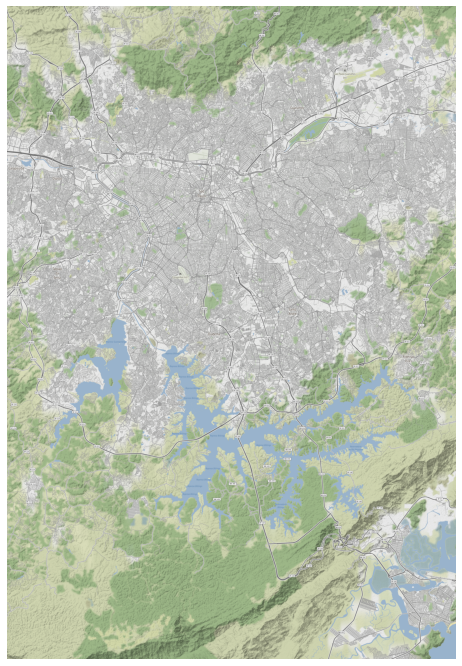

In [40]:
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(sa_image)

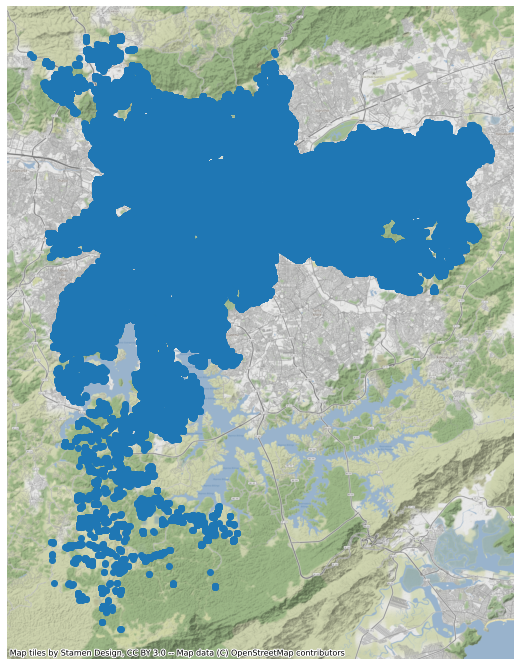

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.axis('off')
#gplt.pointplot(subarvore, ax=ax)
subarvore_df.plot(ax=ax)
ctx.add_basemap(ax, crs='EPSG:4326', zoom=13)

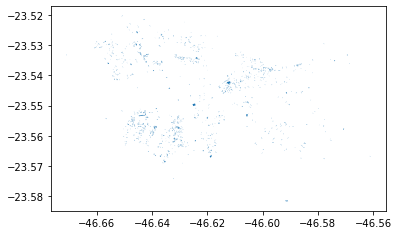

In [43]:
cortico_df.plot()

In [51]:
# https://geopandas.org/geometric_manipulations.html 
from shapely.geometry import Polygon, MultiPolygon

In [66]:
c_midx

-69.95137060042896

In [68]:
c_midx = (c_west+ c_east)/2
c_midy = (c_south+ c_north)/2

print(c_midx, c_midy)

-46.61589309653373 -23.551004039108378


In [69]:
tleft = Polygon([
    (c_west, c_midy),
    (c_midx, c_midy),
    (c_midx, c_north),
    (c_west, c_north),
    (c_west, c_midy)])
print(tleft)

POLYGON ((-46.67095500779045 -23.55100403910838, -46.61589309653373 -23.55100403910838, -46.61589309653373 -23.52016683701657, -46.67095500779045 -23.52016683701657, -46.67095500779045 -23.55100403910838))


tleft = Polygon([
    (c_west, c_midy),
    (c_east, c_midy),#(c_midx, c_midy),
    (c_east, c_north),#(c_midx, c_north),
    (c_west, c_north),
    (c_west, c_midy)])
print(tleft)

In [72]:
cortico_tl_df = gpd.clip(cortico_df, tleft)
cortico_tl_df
#cortico_df.clip(tleft)

,ct_nome,ct_local,ct_qt_pess,ct_area,geometry
ct_id,,,,,
5,Rua Jaguaribe 480,Rua Jaguaribe,0,232.99,"POLYGON ((-46.65249 -23.54122, -46.65244 -23.5..."
7,Rua Martim Francisco 310,Rua Martim Francisco,0,389.84,"POLYGON ((-46.65290 -23.53967, -46.65296 -23.5..."
8,Rua Barra Funda 508,Rua Barra Funda,13,392.27,"POLYGON ((-46.65552 -23.52964, -46.65586 -23.5..."
9,Avenida Mercúrio 214,Avenida Mercúrio,0,351.78,"POLYGON ((-46.62634 -23.54286, -46.62632 -23.5..."
11,Rua Luis Pacheco 287,Rua Luis Pacheco,None,69.25,"POLYGON ((-46.62586 -23.52576, -46.62586 -23.5..."
...,...,...,...,...,...
1458,Rua Bandeirantes 484,Rua Bandeirantes\n,None,501.08,"POLYGON ((-46.63592 -23.52759, -46.63591 -23.5..."
1461,Rua Alexandrino Pedroso 43,Rua Alexandrino Pedroso,11,174.28,"POLYGON ((-46.62329 -23.53223, -46.62322 -23.5..."
1467,Alameda Barão de Piracicaba 193,Alameda Barão de Piracicaba,53,671.46,"POLYGON ((-46.64269 -23.53444, -46.64261 -23.5..."


Wall time: 669 ms


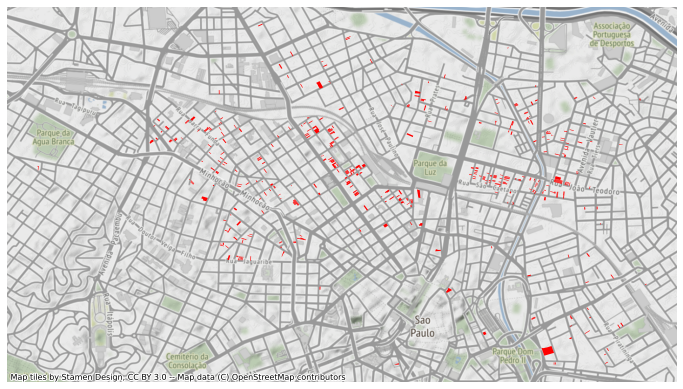

In [76]:
%%time
fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.axis('off')
cortico_tl_df.plot(ax=ax, color='red')
ctx.add_basemap(ax, crs='EPSG:4326')

#fig, ax = plt.subplots(1, 1, figsize=(12,12))
#ax.axis('off')
#cortico_df.plot(ax=ax, color='red')
#ctx.add_basemap(ax, crs='EPSG:4326')

#ax = cortico_df.plot(color='red')
#ctx.add_basemap(ax, crs='EPSG:4326', zoom=8)

#fig, ax = plt.subplots(1, 1, figsize=(12,12))
#ax.axis('off')

#im2, bbox = ctx.bounds2img(c_west, c_south, c_east, c_north, zoom=15, ll=True)
#loc = ctx.Place(w=c_west, s=c_south, e=c_east, n=c_north, zoom_adjust=0)  # zoom_adjust modifies the auto-zoom

#ax=cortico_df.plot(color='red')
#ctx.plot_map(loc, ax=ax)
#ctx.plot_map(im2, bbox, ax=ax)



In [82]:
subarvore_tl_df = gpd.clip(subarvore_df, tleft)

In [83]:
len(subarvore_tl_df)

14690

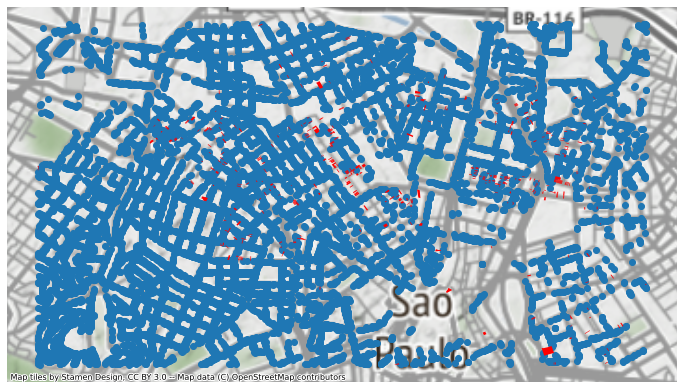

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
ax.axis('off')
subarvore_tl_df.plot(ax=ax)
cortico_tl_df.plot(ax=ax, color='red')
ctx.add_basemap(ax, crs='EPSG:4326', zoom=13)